# 07 - Synthèse des analyses exploratoire des données

In [1]:
import os
current_dir = %pwd
project_dir = os.path.dirname(current_dir)
%cd $project_dir

c:\Users\Bryan Fernandez\Desktop\DataScientest\doc-classifier


c:\Users\Bryan Fernandez\Desktop\DataScientest\doc-classifier\.venv\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# 1. Analyse exploratoire des données physiques des images


Dans cette partie, nous allons analyser les données physiques des images (résolution, netteté, classe,...).


In [2]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

csv_file_path = ('data/raw/image_info_labeled.csv')

df = pd.read_csv(csv_file_path)

## 1.1. Affichage d'échantillons d'images par catégorie


Nous affichons des échantillons d'images de certaines catégories ici du jeu de données data_02 en l'occurence.  
Pour voir tous les échantillons de chaque catégorie par jeu de données, veuillez vous reporter au notebook *00-hryniewski-download-datasets.ipynb* .


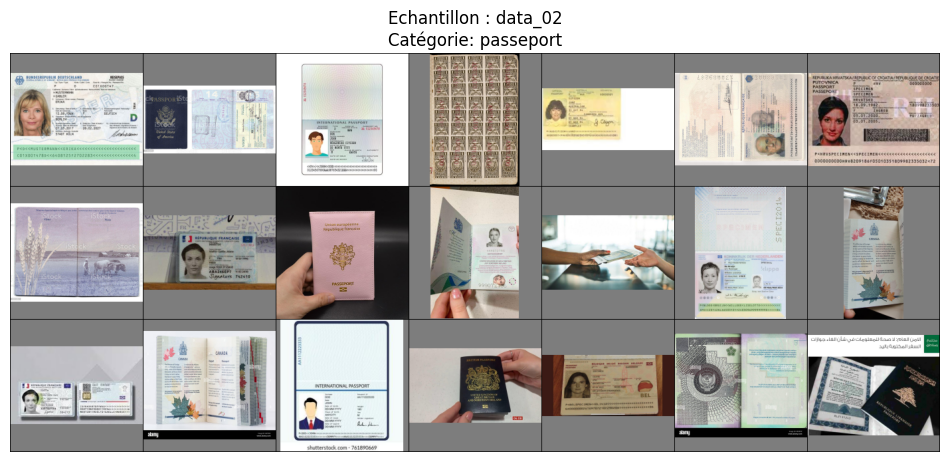

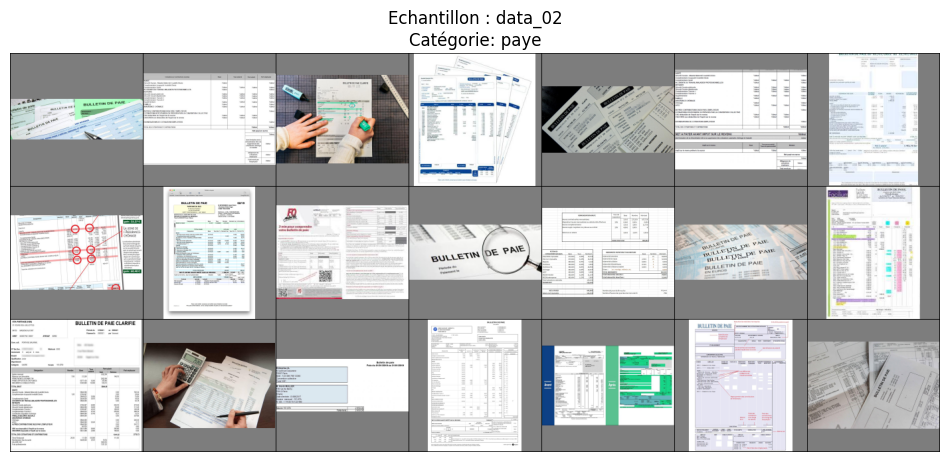

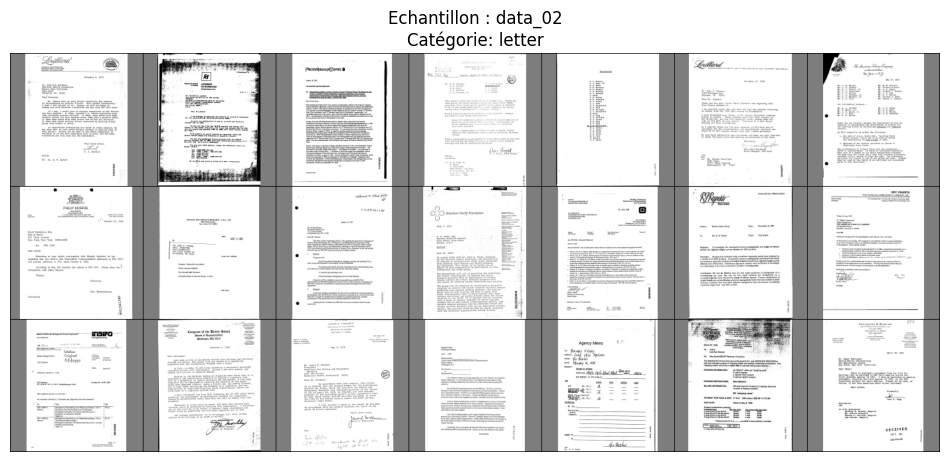

In [3]:
from src import image_grid_sample, plot_image
import random

df_02 = pd.read_csv("data/raw/data_02/other_data.csv")
df_02[["filename", "type"]]

for category in ['passeport', 'paye']+random.sample(df_02['type'].unique().tolist(), 1):
    files = df_02[df_02["type"] == category]["filename"].values
    images_paths = [os.path.join(
        "data/raw/data_02/images", filename) for filename in files]
    image_grid = image_grid_sample(
        images_paths, 3, 7, square_size=200, img_layout='center', seed=42)
    plot_image(image_grid, (12, 10),
               f'Echantillon : data_02\nCatégorie: {category}', flip_image_layers=False)

## 1.2. Répartition des images par catégorie dans les jeux de données


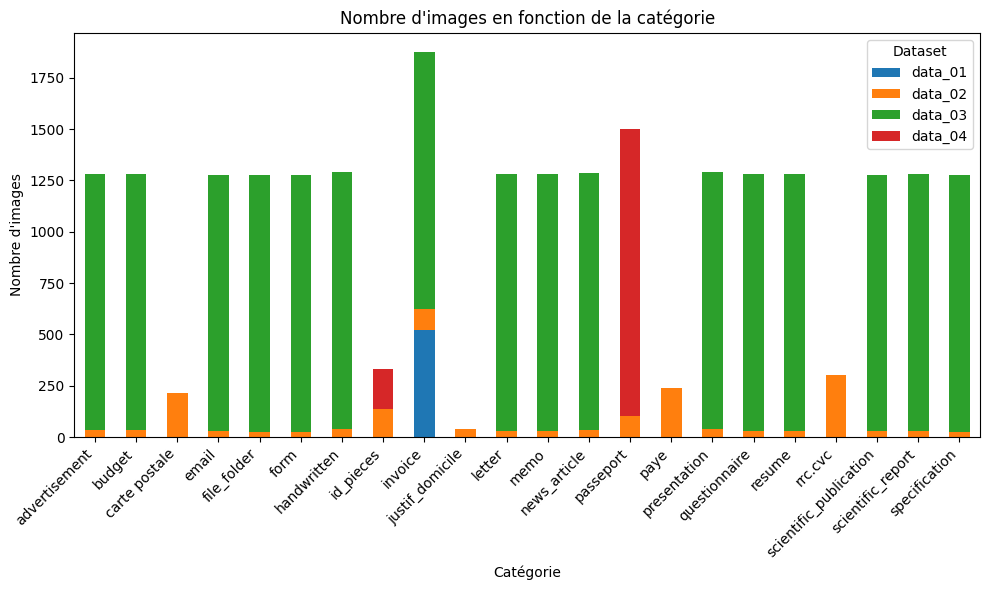

In [4]:
df['label'] = df['label'].replace({'facture': 'invoice'})
df['label'] = df['label'].replace(
    {'id_pieces': 'id_pieces', 'national_identity_card': 'id_pieces'})

counts = df.groupby(['label', 'dataset']).size().unstack(fill_value=0)

# Tracer l'histogramme
counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Nombre d\'images en fonction de la catégorie')
plt.xlabel('Catégorie')
plt.ylabel('Nombre d\'images')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

On peut faire les observations suivantes :

- Les jeux de données data_02 et data_03 comportent des images dans toutes les catégories recensées.
- Le jeu de données data_01 n'est consacré qu'aux factures ("invoice").
- Le jeu de données data_04 n'est consacrée qu'aux pièces d'identité("id_pieces", "passeport").

## 1.3. Analyse de la définition des images


### 1.3.1. Analyse de la définition des images par jeu de données


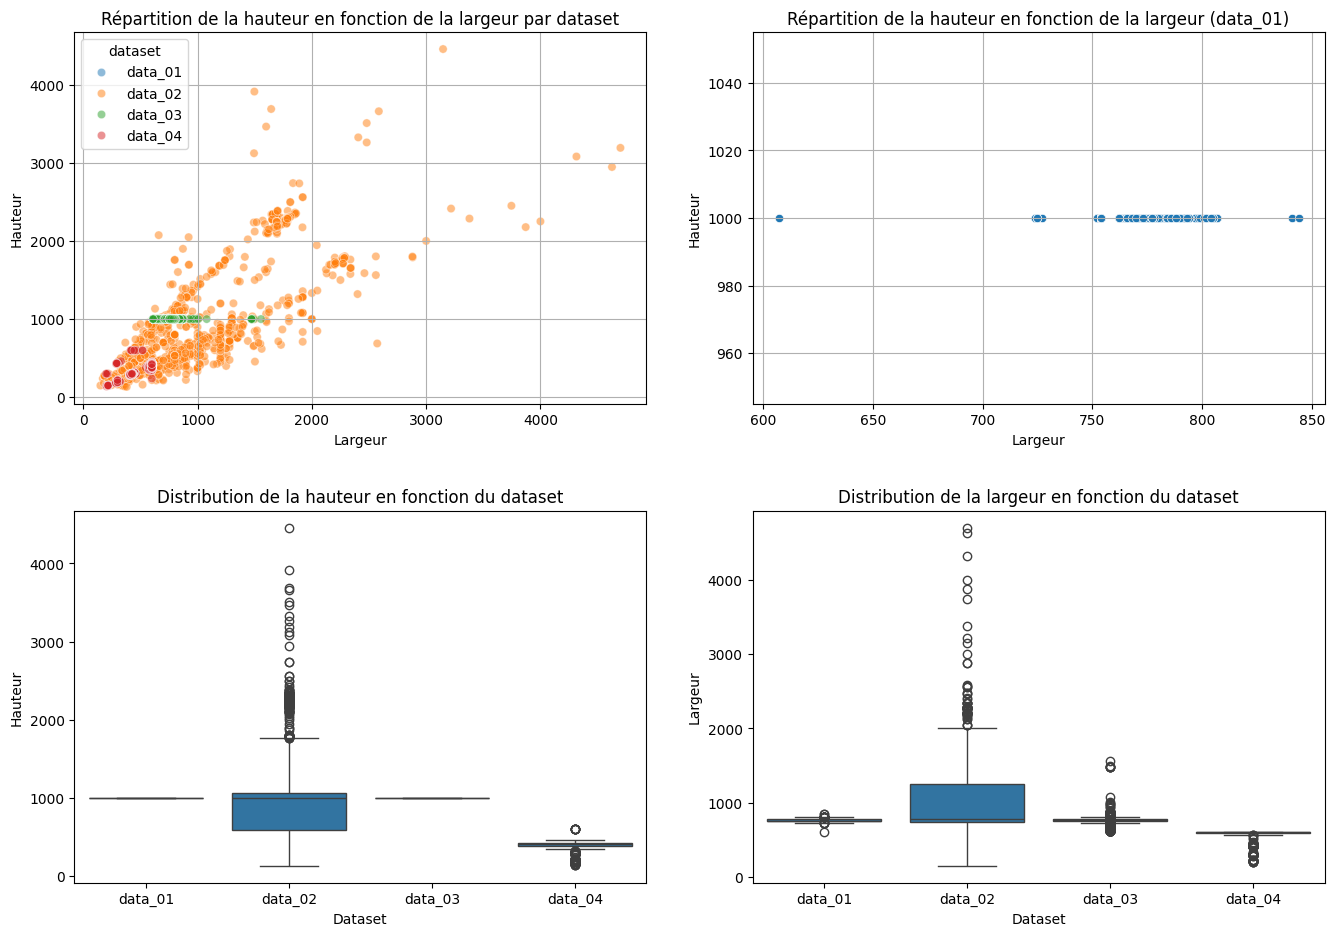

In [5]:
fig = plt.figure(figsize=(14, 10))

plt.subplot(221)
sns.scatterplot(x='width', y='height', hue='dataset', data=df, alpha=0.5)
plt.title('Répartition de la hauteur en fonction de la largeur par dataset')
plt.xlabel('Largeur')
plt.ylabel('Hauteur')
plt.grid(True)

plt.subplot(222)
sns.scatterplot(x='width', y='height', data=df[df['dataset'] == 'data_01'])
plt.title('Répartition de la hauteur en fonction de la largeur (data_01)')
plt.xlabel('Largeur')
plt.ylabel('Hauteur')
plt.grid(True)

plt.subplot(223)
sns.boxplot(data=df, x='dataset', y='height')
plt.title('Distribution de la hauteur en fonction du dataset')
plt.xlabel('Dataset')
plt.ylabel('Hauteur')

# Distribution de la largeur en fonction du dataset
plt.subplot(224)
sns.boxplot(data=df, x='dataset', y='width')
plt.title('Distribution de la largeur en fonction du dataset')
plt.xlabel('Dataset')
plt.ylabel('Largeur')

fig.tight_layout(pad=3.0)
plt.show()

Ces graphes nous permettent de voir l'uniformité de la résolution des images dans chaque jeu de données.  
On remarque les points suivants :

- Les jeux de données data_01 et data_03 ont des images relativement de même résolution. Seule la largeur varie mais relativement peu par rapport au jeu de données data_02.
- Les points du jeu de données data_04 sont fidèles (regroupés ensemble) mais de basse résolution.
- Au contraire, les points du jeu de données data_02 sont plus dispersés.


### 1.3.2. Analyse de la définition des images par catégorie par jeu de données


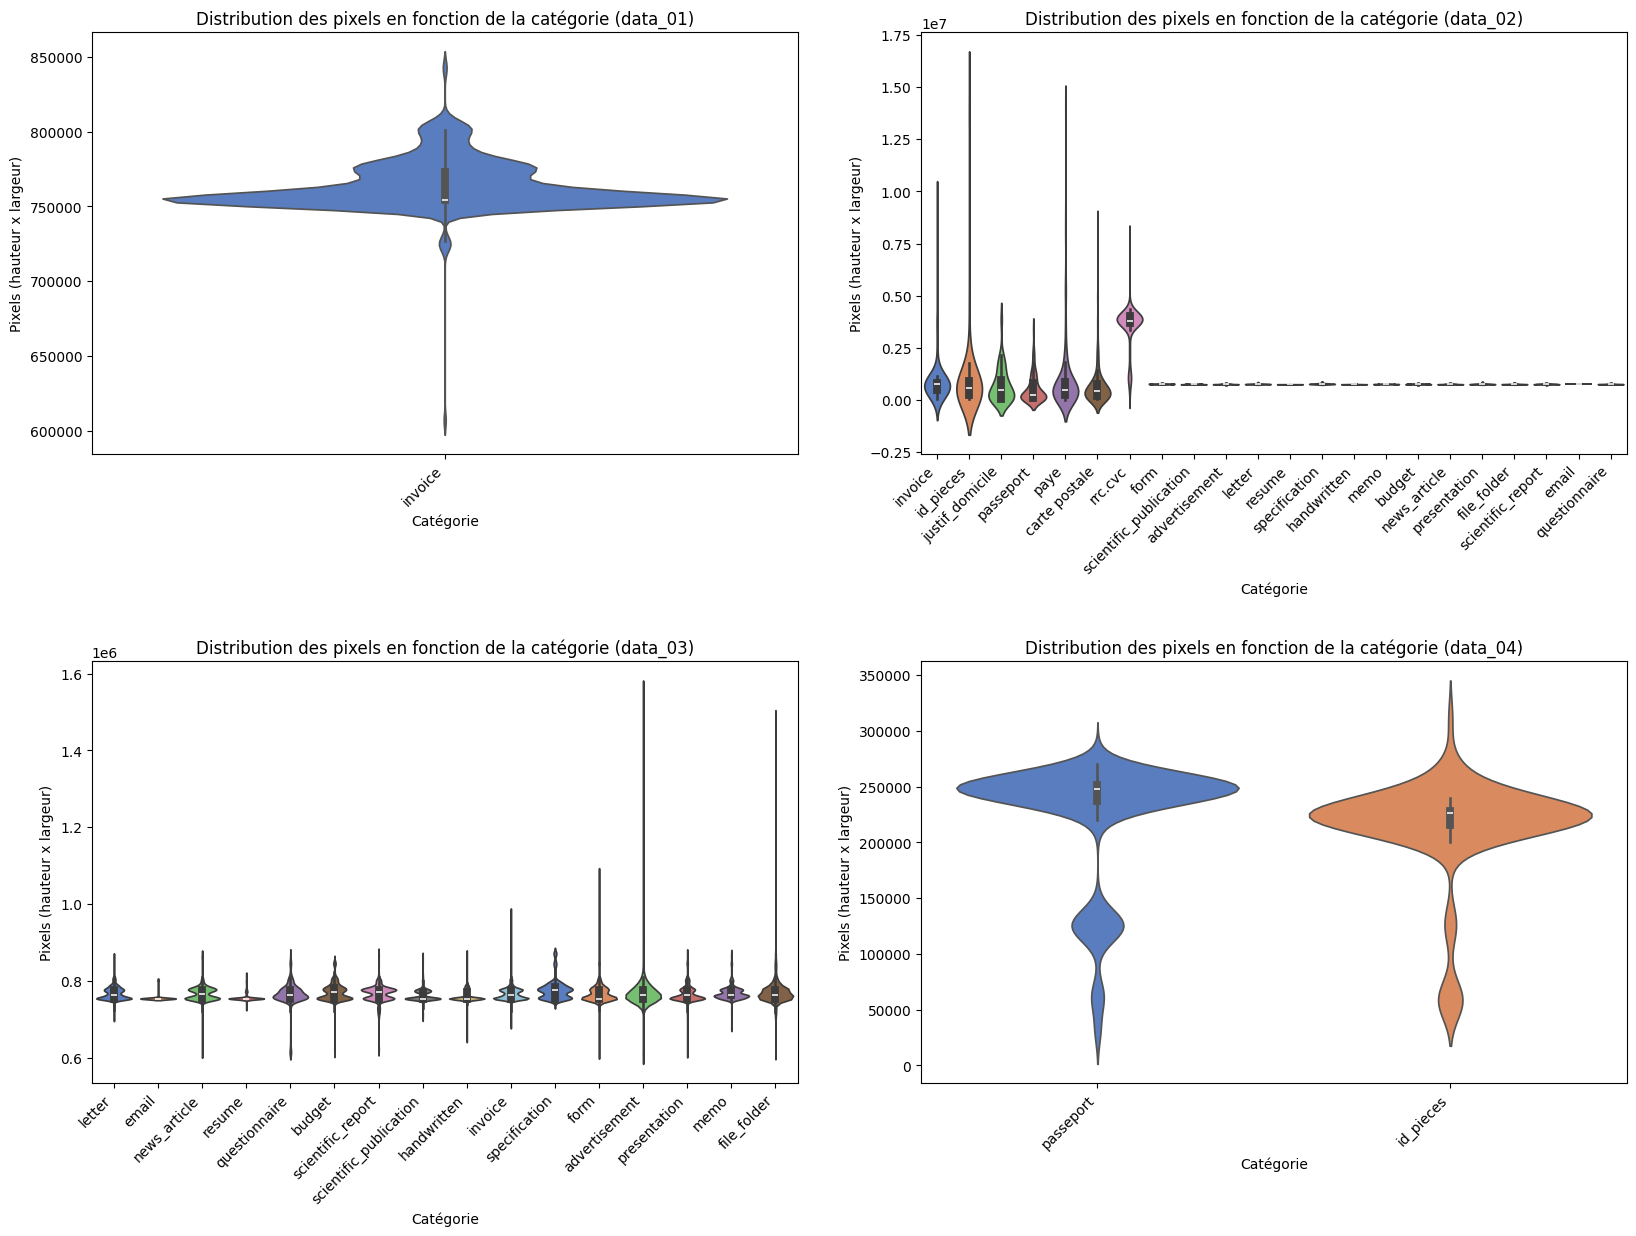

In [6]:
c = 1
fig = plt.figure(figsize=(17, 13))

for dataset in ['data_01', 'data_02', 'data_03', 'data_04']:
    # Make a copy to avoid SettingWithCopyWarning
    sub_data = df[df['dataset'] == dataset].copy()
    sub_data.loc[:, 'pixels'] = sub_data['height'] * sub_data['width']

    plt.subplot(2, 2, c)
    sns.violinplot(data=sub_data, x='label', y='pixels',
                   hue='label', palette="muted")
    plt.title(
        f'Distribution des pixels en fonction de la catégorie ({dataset})')
    plt.xlabel('Catégorie')
    plt.ylabel('Pixels (hauteur x largeur)')
    plt.xticks(rotation=45, ha='right')
    c = c + 1

fig.tight_layout(pad=3.0)
plt.show()

- Dans le jeu de données data_01, la distribution est moins étendue.
- Dans le jeu de données data_03, nous avons deux catégories présentant des valeurs aberrantes : "advertisement" et "file_folder".
- Dans le jeu de données data_02, certaines catégories présentent des images de taille uniforme, telles que 'form', 'scientific_publication', etc.
- Dans le jeu de donnée data_02 nous avons des valeurs aberrantes comme dans les catégories "invoice", "id_pieces", "paye" et "carte_postale".


# 1.4. Analyse du flou des images par jeu de données


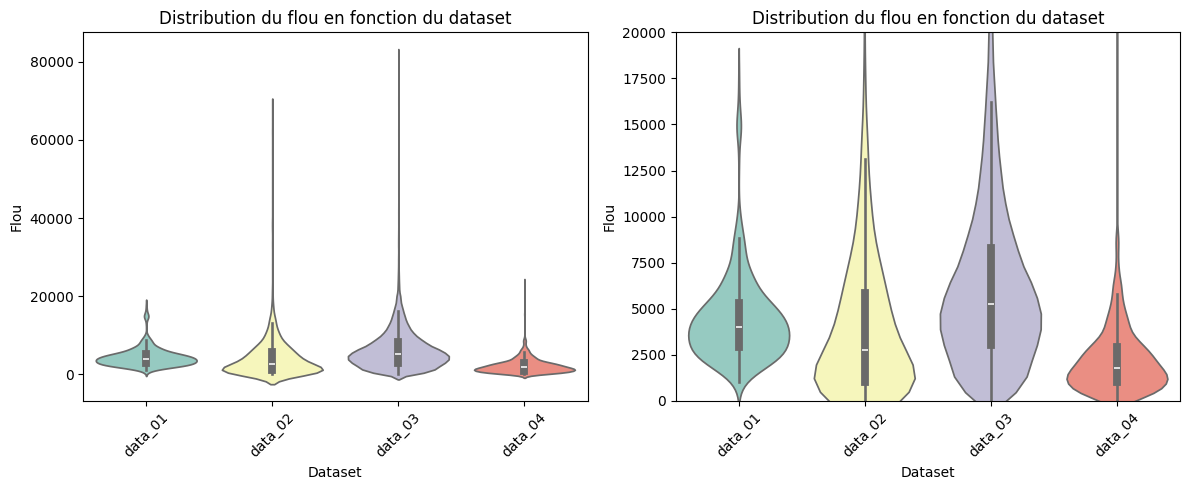

In [7]:
fig = plt.figure(figsize=(12, 5))

plt.subplot(121)
sns.violinplot(x='dataset', y='bluriness', hue='dataset',
               data=df, palette='Set3', legend=False)
plt.title('Distribution du flou en fonction du dataset')
plt.xlabel('Dataset')
plt.ylabel('Flou')
plt.xticks(rotation=45)

plt.subplot(122)
sns.violinplot(x='dataset', y='bluriness', hue='dataset',
               data=df, palette='Set3', legend=False)
plt.title('Distribution du flou en fonction du dataset')
plt.xlabel('Dataset')
plt.ylabel('Flou')
plt.ylim((0, 20000))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [8]:
# Cette cellule permet d'afficher 3 images qui ont un score de flou en dessous du seuil fixé arbitrairement (ici 60)

def show_image(image_path):
    """
    Displays the image in a window and waits for the user to press any key to close the window.

    Args:
        image_path (str): The path of the image to be displayed.
    """
    image = cv2.imread(image_path)
    if image is not None:
        cv2.namedWindow("Resized_Window", cv2.WINDOW_NORMAL)
        cv2.resizeWindow("Resized_Window", 700, 400)
        cv2.imshow("Resized_Window", image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        print(f"Unable to read the image: {image_path}")


threshold = 60
blurred_images = df[df['bluriness'] < threshold]

for image in random.sample(blurred_images['path'].tolist(), 3):
    show_image(image)

print(f'Il y a {blurred_images.value_counts().sum()} images ayant un score en dessous du seuil de {threshold}')

Il y a 12 images ayant un score en dessous du seuil de 60


Cette partie nous montre les images floues. Plus le score est bas, plus l'image est floue. Ici nous avons fixé un seuil à 60. Après quelques observations, les images ayant un score au delà de ce seuil sont assez nettes et lisibles.


## 1.5. Analyse des histogrammes des couleurs des jeux de données


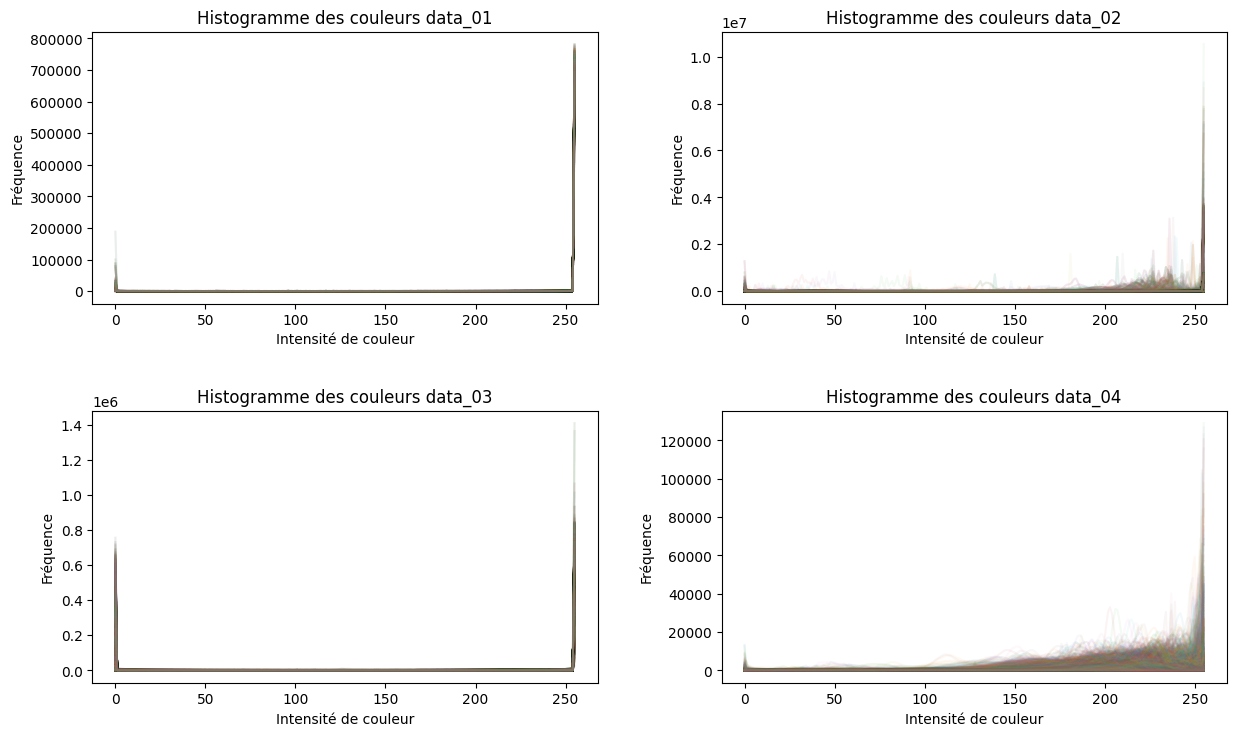

In [9]:
from src import compute_color_histogram

c = 1
fig = plt.figure(figsize=(13, 8))

for dataset in ['data_01', 'data_02', 'data_03', 'data_04']:

    image_folder = f'data/raw/{dataset}/images'

    all_histograms = []

    for filename in os.listdir(image_folder):

        image_path = os.path.join(image_folder, filename)
        histograms = compute_color_histogram(image_path)
        all_histograms.extend(histograms)

    plt.subplot(2, 2, c)
    for histogram in all_histograms:
        plt.plot(histogram, alpha=0.05)
    plt.title(f'Histogramme des couleurs {dataset}')
    plt.xlabel('Intensité de couleur')
    plt.ylabel('Fréquence')
    c = c+1

fig.tight_layout(pad=3.0)
plt.show()

- Les jeux de données data_01 et data_03 sembleraient être composés exclusivement d'images en noir et blanc, car les histogrammes des couleurs ne montrent aucune variation significative de couleurs entre 0 et 255.
- Les jeux de données data_02 et data_04 comportent des images en couleur, comme on peut le voir dans la variation des courbes dans les histogrammes des couleurs.


# 2. Analyse exploratoire des données textuelles dans les images


Ici nous traitons la globalité des jeux de données en un (data_01 + data_02 + data_03 + data_04). Nous avons extrait les mots des images et les avons exportés dans un fichier .csv .

In [10]:
# CHargement des jeux de données textuelles

from collections import Counter
from src import barplot, create_wordcloud

df1 = pd.read_csv("data/raw/data_01/text_process.csv")
df2 = pd.read_csv("data/raw/data_02/text_process.csv")
df3 = pd.read_csv("data/raw/data_03/text_process.csv")
df4 = pd.read_csv("data/raw/data_04/text_process.csv")

df1['words'] = df1['words'].apply(lambda x: x.split(' ') if isinstance(x, str) else [])
df2['words'] = df2['words'].apply(lambda x: x.split(' ') if isinstance(x, str) else [])
df3['words'] = df3['words'].apply(lambda x: x.split(' ') if isinstance(x, str) else [])
df4['words'] = df4['words'].apply(lambda x: x.split(' ') if isinstance(x, str) else [])

df1['words_count'] = df1['words'].apply(lambda x: len(x))
df2['words_count'] = df2['words'].apply(lambda x: len(x))
df3['words_count'] = df3['words'].apply(lambda x: len(x))
df4['words_count'] = df4['words'].apply(lambda x: len(x))

df1['dataset'] = 'data_01'
df2['dataset'] = 'data_02'
df3['dataset'] = 'data_03'
df4['dataset'] = 'data_04'

df2['category'] = df2['category'].str.replace('facture', 'invoice')

df = pd.concat([df1, df2, df3, df4])

## 2.1. Distribution des langues dans l'ensemble des jeux de données

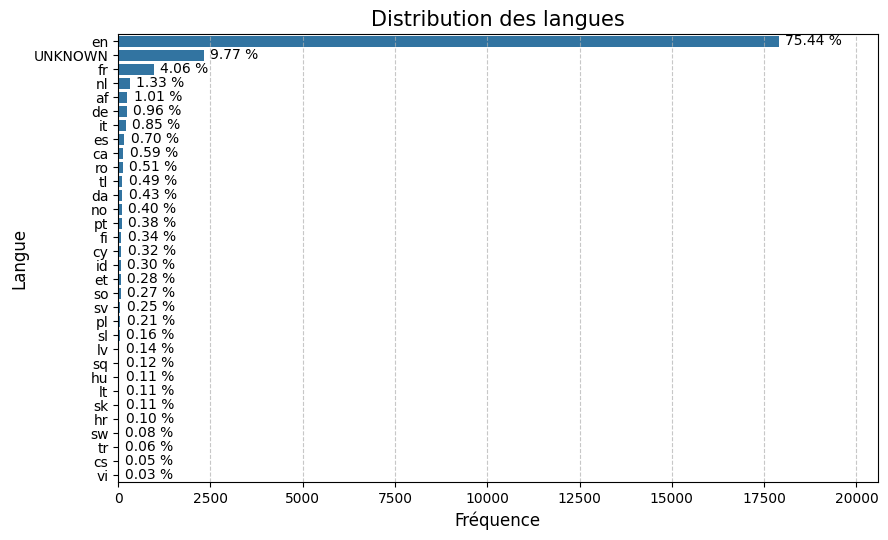

In [11]:
count = df['lang'].value_counts()
barplot(x=count.values,
        y=count.index,
        figsize=(9, 5.5),
        xlabel='Fréquence',
        ylabel='Langue',
        title=f'Distribution des langues')

On peut rapidement remarquer que la langue anglaise est la plus présente dans notre jeu de données global représentant 75.44%. La deuxième langue connue est le français. Les autres langues représentent chacune d'elle que'une infime partie du jeu de données global.

## 2.2. Distribution du nombre de mots par page par catégorie 

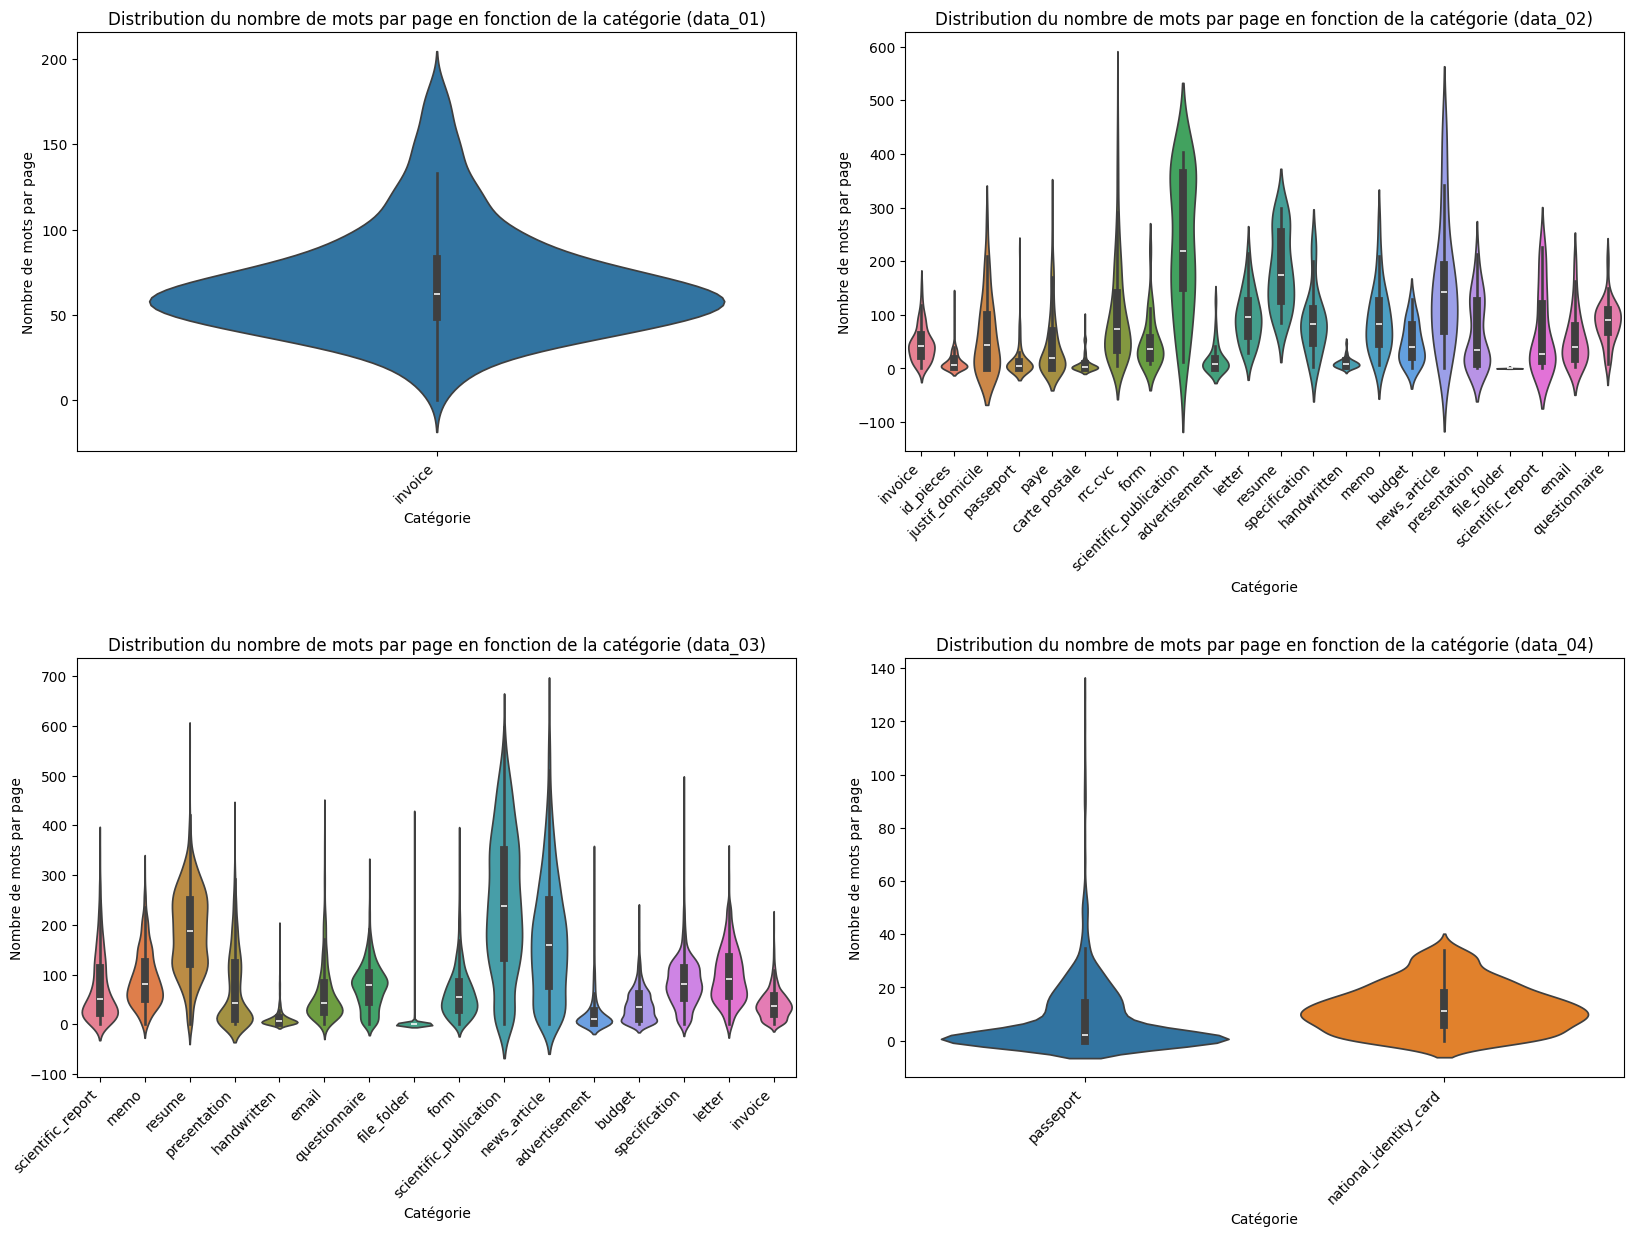

In [12]:
c = 1
fig = plt.figure(figsize=(17, 13))

for dataset in ['data_01', 'data_02', 'data_03', 'data_04']:

    sub_data = df[df['dataset'] == dataset].copy()

    plt.subplot(2, 2, c)
    sns.violinplot(data=sub_data, x='category',
                   y='words_count', hue='category')
    plt.title(
        f'Distribution du nombre de mots par page en fonction de la catégorie ({dataset})')
    plt.xlabel('Catégorie')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Nombre de mots par page')

    c = c + 1

fig.tight_layout(pad=3.0)
plt.show()

Le but de ces graphes étaient de voir si le nombre de mots par page était uniforme à travers les différentes catégories (petite étendue en y). Cependant on remarque que de nombreuses catégories on des densités différentes notamment les catégories supposé comporter énormément de textes telles que "scientific_publication" et "news_article". Néanmoins, on peut voir que certaines catégories ont la densité la plus larges au niveau de la médiane telles que "passeport", "invoice" et "advertissement" par exemple.

## 2.3. Quels mots caractérisent chaque catégorie ?

Nous affons les nuages de mots de chaque catégories pour voir quels sont les mots les plus fréquents.  
Pour voir la totalité des luages de mots, veuillez vous reporter au notebook *05-hryniewski-tesseract-analysis.ipynb* .

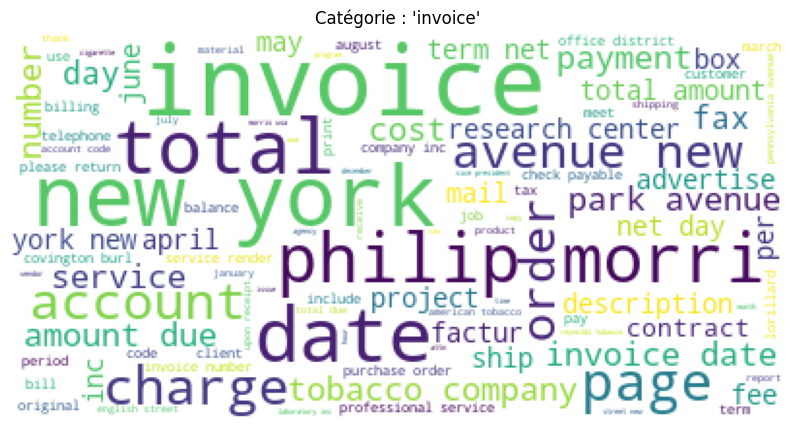

In [13]:
df_cat = df[df['category'] == 'invoice']
cat_words = df_cat['words'].sum()
create_wordcloud(cat_words, title=f"Catégorie : 'invoice'", figsize=(10, 9))

In [14]:
categories = []
values = []
for category in df['category'].unique():
    df_cat = df[df['category'] == category]

    word_freq = Counter(df_cat['words'].sum())
    top_words = word_freq.most_common()
    top_words, frequencies = zip(*top_words)

    f_percent = [value/sum(frequencies)*100 for value in frequencies]
    values.append([sum(f_percent[:5]), sum(f_percent[:10]),
                  sum(f_percent[:25]), sum(f_percent[:50])])
    categories.append(category)

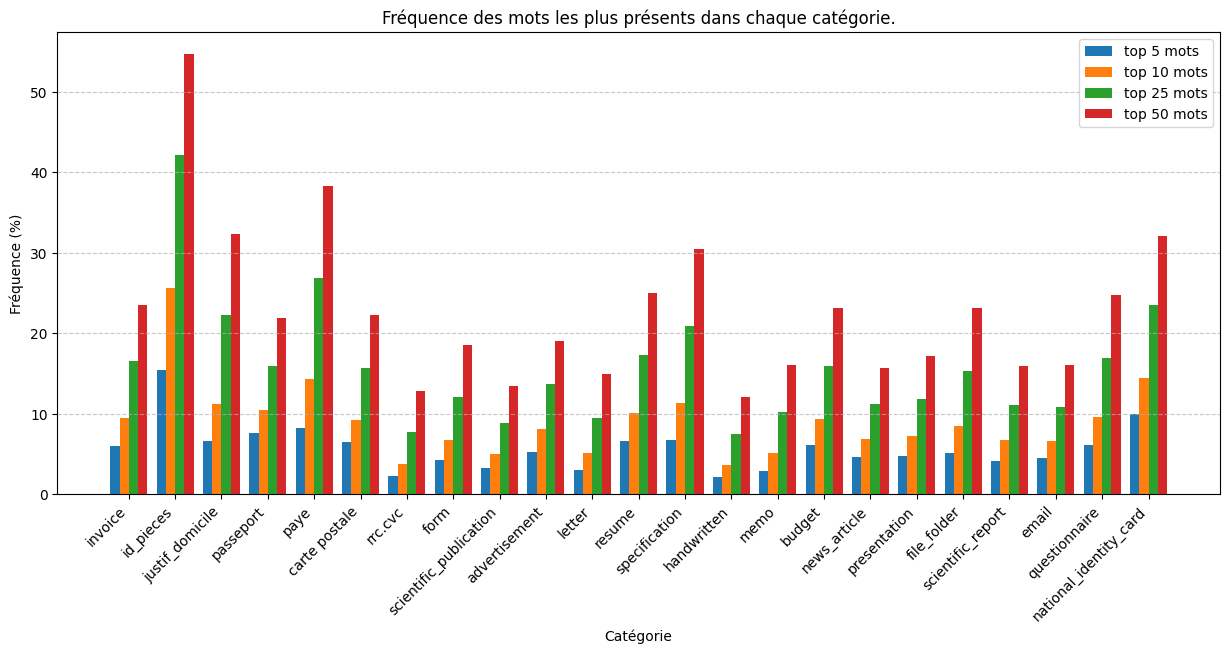

In [15]:
import numpy as np


vals = np.array(values)
bar_size = 0.2
x = np.arange(len(categories))
# Créer le graphique
plt.figure(figsize=(15, 6))
for i in range(len(vals[0])):
    plt.bar(x + i * bar_size, vals[:, i],
            width=bar_size, label=f'Valeur {i+1}')


plt.title('Fréquence des mots les plus présents dans chaque catégorie.')
plt.xlabel('Catégorie')
plt.ylabel('Fréquence (%)')
plt.xticks(x + bar_size * (len(vals[0]) - 1) / 2, categories)
plt.legend(labels=['top 5 mots', 'top 10 mots', 'top 25 mots', 'top 50 mots'])
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Afficher le graphique
plt.show()

Ce graphe est très intéressant si l'on souhaite faire de la classification par texte. Il nous permet de voir quel pourcentage on obtient en fonction du nombre de mots les plus fréquents la totalité des mots par catégorie.  
Prenons par exemple la catégorie "invoice" : Les 10 mots les plus fréquents de cette catégorie ne présentent même pas 10% de la totalité des mots de la catégorie. Mais les 50 mots les plus fréquents représentent plus de 20% des mots de la catégorie.

# 3. Conclusion
Cette partie d'exploration des données nous permet de mieux comprendre les données que nous avons en entrée.  
  
Nous avons découvert dans un premier temps, lors de l'affichage des échantillons, que des images du jeu de données data_02 n'étaient pas catégorisées correctement (ex : on trouve des cartes d'identité dans la catégorie "passeport"). Ceci était un point à prendre en compte dans la suite de nos analyses car nous faisons plusieurs divisions par catégorie au sein des jeux de données.  
  
Dans la première partie, l'analyse des données physiques des images nous a permis de voir que les définitions des images dans les jeux de données data_01, data_03 et data_04 étaient relativement uniformes comparées au jeu de données data_02 qui lui est beaucoup plus dispersé. La quantité d'images floues dans la globalité n'est pas énorme (12 images en dessous du seuil). Enfin, nous avons vu les différents espaces colorimétriques par jeu de données.  
Dans la deuxième partie, correspondant à l'analyse des textes au sein des images, nous avons pu extraire les langues dans les images. Puis nous avons fait une analyse des fréquences des mots qui nous permet de voir dans un premier temps quels mots caractérisent les catégories mais aussi à partir de quel nombre de mots les plus fréquents nous atteignons un seuil représentatif des catégories.  
  
Ces analyses nous ont permis de conclure que le jeu de données data_02 n'est pas suffisamment exploitable pour la suite de notre projet car trop d'images ne sont pas catégorisées correctement. Il nous arrive souvent de tomber sur des images dont le contenu est bien catégorisé mais ne représente pas beaucoup d'intérêt (ex : image avec écrit en gros 'Bulletin de paie' et puis rien d'autre). De plus, les tailles des images sont beaucoup trop différentes dans chaque catégorie du jeu de données.  
Nous avons donc décidé d'abandonner le jeu de données data_02.  
  
Ces analyses nous permettront aussi de définir pour la suite les fonctions de prétraitement qui nous permettront d'uniformiser les images mais aussi les textes pour la construction des pipelines d'images et pipelines de texte.  
  
Enfin, nous avons décidé de garder les catégories suivantes :  
  
-Passeport  
-National ID card  
-Email  
-Invoice  
-Scientific publication  
Handwritten  
Ces classes sont les plus pertinentes pour une application concrète dans la vie réelle et nous avons un large jeu de données équilibré en quantité entre les classes. De plus, les images sont assez nettes (scannées).  